In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool
from PIL import Image

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Saliency

In [2]:
def normalize(arr): return (arr - arr.mean()) / arr.std()

In [3]:
model_name = f"DenseNet121_v1_Cardiomegaly"
label = "Cardiomegaly"
s = 224
image_size = (s, s)#(224, 224)
labels = get_labels()
bs = 1
device = get_cpu()

Using the CPU!


In [4]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, 
                                             small=False)
print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df = get_binary_df(label, test_df)

train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
print(neg_weights, pos_weights)

train_tfs, test_tfs = get_transforms(image_size=image_size)

train_ds = CRX8_Data(train_df, get_image_path(), label, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), label, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), label, image_size=image_size, transforms=test_tfs)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)
dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

criterion = get_weighted_loss_with_logits(pos_weights.to(device), 
                                          neg_weights.to(device))

/home/favi/work/crx8/exp/utils.py:179: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


(69219, 24) (17305, 24) (25596, 24)
tensor([0.0198]) tensor([0.9802])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224]) torch.Size([1, 1]) tensor([[1.]])


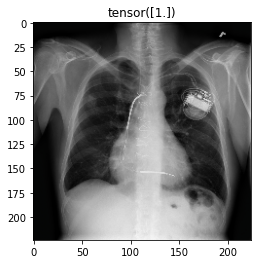

In [5]:
i = 0
pos_count = 0
target_pos = 1
X, y = get_batch(i, test_dl)
while True:
    if y.sum() > 0: pos_count += 1
    if pos_count == target_pos: break
    i += 1
    X, y = get_batch(i, test_dl)
print(X.shape, y.shape, y)
print_image(X[0], y[0])

In [6]:
model = load_model(model_name)
model.eval();

In [7]:
X, y, model = X.to(device), y.to(device), model.to(device)

In [8]:
pred_prob, _ = torch.topk(NN.Sigmoid()(model(X)), 1)
pred_label = (pred_prob >= 0.5).float()
label_idx = 0
pred_prob, pred_label

(tensor([[0.6460]], grad_fn=<TopkBackward>), tensor([[1.]]))

In [59]:
default_cmap = LinearSegmentedColormap.from_list("red",[(0, '#000000'),
                                                  (0.25, '#000000'),
                                                  (1, '#fc7b02')], N=256 )


In [9]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attrs = []
for _ in range(20):
    model.zero_grad()
    tmp = nt.attribute(X, #target=pred_label,
                       baselines=X * 0, 
                       nt_type='smoothgrad_sq',
                       nt_samples=2, stdevs=0.2)
    attrs.append(tmp.squeeze())
    #array_info(tmp[0]);print()

In [ ]:
#array_info(attrs[0])

In [10]:
attr_ig_nt = torch.zeros((len(attrs), *attrs[0].shape))
for i in range(len(attrs)): attr_ig_nt[i] = attrs[i][0]
    
attr_ig_nt = attr_ig_nt.mean(axis=0).cpu().detach().numpy()
array_info(attr_ig_nt);print()
attr_ig_nt = np.transpose(attr_ig_nt, (1, 2, 0))

Shape:	 (3, 224, 224)
Mean:	 1.7235764e-06
Std:	 1.6798425e-05
Max:	 0.0011209606
Min:	 7.5914196e-14



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


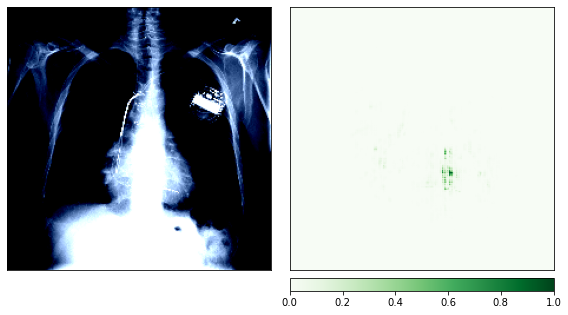

In [11]:
_ = viz.visualize_image_attr_multiple(attr_ig_nt,
                                      np.transpose(X[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                     # cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


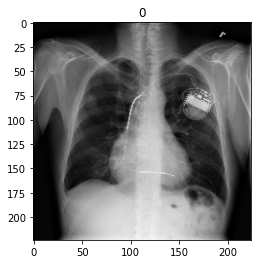

In [19]:
print_image(X[0], 0)

In [20]:
transformed_img = X[0].cpu().detach().numpy()
transformed_img = np.einsum("cwh -> whc", transformed_img)
transformed_img = transformed_img * IMAGENET_STD + IMAGENET_MEAN

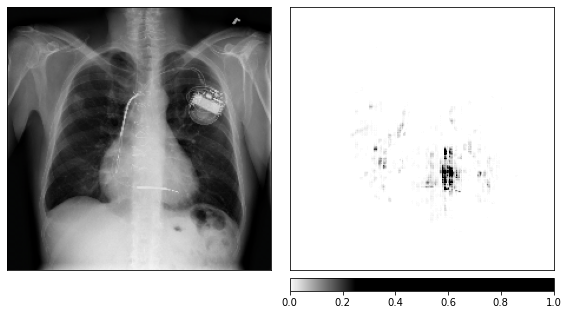

In [21]:
_ = viz.visualize_image_attr_multiple(attr_ig_nt,
                                      transformed_img,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [22]:
array_info(attr_ig_nt)

Shape:	 (224, 224, 3)
Mean:	 1.7235764e-06
Std:	 1.6798425e-05
Max:	 0.0011209606
Min:	 7.5914196e-14


In [23]:
def range_it(arr):
    arr += arr.min()
    arr /= arr.max()
    return arr

In [24]:
r_attr = range_it(attr_ig_nt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


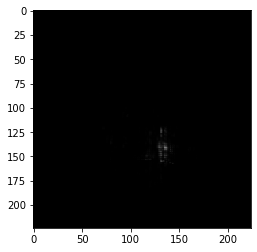

In [29]:
plt.imshow(transformed_img * r_attr, cmap="gray")

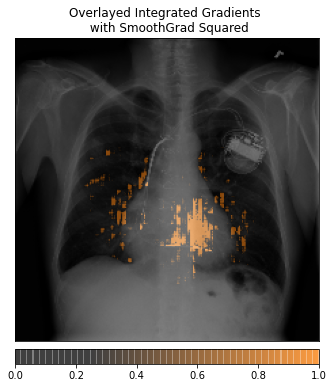

In [63]:
_ = viz.visualize_image_attr(attr_ig_nt, 
                             transformed_img, 
                             method="blended_heat_map", 
                             sign="absolute_value", 
                             outlier_perc=70, 
                             show_colorbar=True,
                             cmap=default_cmap,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")